<a href="https://colab.research.google.com/github/SuhailKider/EV-CAN-IDS/blob/main/EV_CAN_IDS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# EV CAN BUS INTRUSION DETECTION SYSTEM
# Google Colab Implementation
# ============================================================================

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages (if not already installed)
!pip install -q pandas numpy scikit-learn scipy

# Import libraries
import pandas as pd
import numpy as np
import re
import json
from pathlib import Path
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("EV CAN BUS INTRUSION DETECTION SYSTEM")
print("=" * 70)
print("\nLibraries imported successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
EV CAN BUS INTRUSION DETECTION SYSTEM

Libraries imported successfully!


In [3]:
# ============================================================================
# FILE PATHS CONFIGURATION
# ============================================================================

# Define dataset paths
DATASET_PATHS = {
    'normal': "/content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Data/Attack_free_dataset.txt",
    'dos': "/content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Data/DoS_attack_dataset.txt",
    'fuzzy': "/content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Data/Fuzzy_attack_dataset.txt",
    'impersonation': "/content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Data/Impersonation_attack_dataset.txt"
}

# Output directory
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Output"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("File paths configured:")
for name, path in DATASET_PATHS.items():
    exists = Path(path).exists()
    status = "✓" if exists else "✗"
    print(f"  {status} {name}: {path}")

print(f"\nOutput directory: {OUTPUT_DIR}")

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def payload_array_from_row(row):
    """Extract payload as numpy array"""
    return np.array([int(row[f'DATA{i}']) for i in range(8)], dtype=np.int32)

def hamming_distance(a, b):
    """Calculate bit-level Hamming distance between two payload arrays"""
    x = np.bitwise_xor(a.astype(np.uint8), b.astype(np.uint8))
    return int(np.unpackbits(x.view(np.uint8)).sum())

def parse_can_line(line: str):
    """Parse a CAN log line to extract timestamp, ID, DLC, and payload"""
    pattern = r'Timestamp:\s+([\d.]+)\s+ID:\s+([0-9a-fA-F]+)\s+\d+\s+DLC:\s+(\d+)\s+(.+)'
    match = re.match(pattern, line.strip())
    if not match:
        return None

    timestamp = float(match.group(1))
    id_hex = match.group(2).lower()
    dlc = int(match.group(3))

    # Parse data bytes (hex)
    data_str = match.group(4).strip()
    hex_bytes = re.findall(r'[0-9a-fA-F]{2}', data_str)
    data_bytes = [int(hb, 16) for hb in hex_bytes[:8]]

    # Pad to 8 bytes
    while len(data_bytes) < 8:
        data_bytes.append(0)

    return {
        'Timestamp': timestamp,
        'ID': id_hex,
        'DLC': dlc,
        'DATA0': data_bytes[0], 'DATA1': data_bytes[1],
        'DATA2': data_bytes[2], 'DATA3': data_bytes[3],
        'DATA4': data_bytes[4], 'DATA5': data_bytes[5],
        'DATA6': data_bytes[6], 'DATA7': data_bytes[7]
    }

def convert_dataset(txt_path, label, limit=None):
    """Convert .txt CAN dataset to DataFrame"""
    rows = []
    file_path = Path(txt_path)

    if not file_path.exists():
        print(f"✗ File not found: {txt_path}")
        return None

    print(f'Converting {file_path.name} (label={label})...')

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i, line in enumerate(f):
            if limit and i >= limit:
                break
            if i % 50000 == 0 and i > 0:
                print(f'  Processed {i:,} lines...')

            parsed = parse_can_line(line)
            if parsed:
                parsed['label'] = label
                rows.append(parsed)

    df = pd.DataFrame(rows)
    print(f'  ✓ Converted {len(df):,} rows\n')
    return df

print("\n✓ Helper functions defined successfully!")

File paths configured:
  ✓ normal: /content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Data/Attack_free_dataset.txt
  ✓ dos: /content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Data/DoS_attack_dataset.txt
  ✓ fuzzy: /content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Data/Fuzzy_attack_dataset.txt
  ✓ impersonation: /content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Data/Impersonation_attack_dataset.txt

Output directory: /content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Output

✓ Helper functions defined successfully!


In [4]:
# ============================================================================
# STEP 1: DATA LOADING AND CONVERSION
# ============================================================================

print("=" * 70)
print("STEP 1: LOADING AND CONVERTING DATASETS")
print("=" * 70)

# Set limit=None for full dataset, or use limit=100000 for quick testing
LIMIT = None  # Change to 100000 for faster testing

# Convert datasets
datasets_config = {
    'normal': (DATASET_PATHS['normal'], 0),
    'dos': (DATASET_PATHS['dos'], 1),
    'fuzzy': (DATASET_PATHS['fuzzy'], 1),
    'impersonation': (DATASET_PATHS['impersonation'], 1)
}

converted = {}
for name, (file_path, label) in datasets_config.items():
    df = convert_dataset(file_path, label, limit=LIMIT)
    if df is not None:
        converted[name] = df

# Verify datasets loaded
if 'normal' not in converted:
    raise FileNotFoundError("Normal dataset (Attack_free_dataset.txt) not found!")

# Create training set (normal only)
train_df = converted['normal'].copy()
print(f"\n Training Dataset: {len(train_df):,} rows (normal only, label=0)")

# Create test set (all attacks + 10% normal for balanced testing)
test_dfs = []
for name in ['dos', 'fuzzy', 'impersonation']:
    if name in converted:
        test_dfs.append(converted[name])
        print(f"  - Added {name}: {len(converted[name]):,} rows")

# Add 10% normal data to test set for false positive rate calculation
normal_sample_size = len(train_df) // 10
normal_test = train_df.tail(normal_sample_size).copy()
test_dfs.append(normal_test)
print(f"  - Added normal sample: {len(normal_test):,} rows")

# Combine test datasets
test_df = pd.concat(test_dfs, ignore_index=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

print(f"\n Test Dataset: {len(test_df):,} total rows")
print(f"  - Normal (label=0): {(test_df['label']==0).sum():,}")
print(f"  - Attacks (label=1): {(test_df['label']==1).sum():,}")

print("\n Datasets loaded successfully!")

STEP 1: LOADING AND CONVERTING DATASETS
Converting Attack_free_dataset.txt (label=0)...
  Processed 50,000 lines...
  Processed 100,000 lines...
  Processed 150,000 lines...
  Processed 200,000 lines...
  Processed 250,000 lines...
  Processed 300,000 lines...
  Processed 350,000 lines...
  Processed 400,000 lines...
  Processed 450,000 lines...
  Processed 500,000 lines...
  Processed 550,000 lines...
  Processed 600,000 lines...
  Processed 650,000 lines...
  Processed 700,000 lines...
  Processed 750,000 lines...
  Processed 800,000 lines...
  Processed 850,000 lines...
  Processed 900,000 lines...
  Processed 950,000 lines...
  Processed 1,000,000 lines...
  Processed 1,050,000 lines...
  Processed 1,100,000 lines...
  Processed 1,150,000 lines...
  Processed 1,200,000 lines...
  Processed 1,250,000 lines...
  Processed 1,300,000 lines...
  Processed 1,350,000 lines...
  Processed 1,400,000 lines...
  Processed 1,450,000 lines...
  Processed 1,500,000 lines...
  Processed 1,550,000

In [5]:
# ============================================================================
# STEP 2: FEATURE ENGINEERING FUNCTIONS
# ============================================================================

print("=" * 70)
print("STEP 2: FEATURE ENGINEERING")
print("=" * 70)

def add_basic_timing_features(df):
    """Add basic timing features - Objective 2: Preprocessing"""
    df = df.sort_values('Timestamp').reset_index(drop=True)
    df['delta_time'] = df['Timestamp'].diff().fillna(0.0)
    df['delta_time_id'] = df.groupby('ID')['Timestamp'].diff().fillna(0.0)
    return df

def add_rolling_stats_per_id(df, window=20):
    """Add rolling statistics per CAN ID - Detects DoS attacks"""
    # Rolling mean and std of delta_time per ID
    df['rolling_mean_delta_id'] = df.groupby('ID')['delta_time_id'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())
    df['rolling_std_delta_id'] = df.groupby('ID')['delta_time_id'].transform(
        lambda x: x.rolling(window, min_periods=1).std().fillna(0.0))

    # Message frequency per ID
    df['id_count_window'] = df.groupby('ID')['ID'].transform(
        lambda x: x.rolling(window, min_periods=1).count())
    df['rolling_time_span_id'] = df.groupby('ID')['Timestamp'].transform(
        lambda x: x.rolling(window, min_periods=1).apply(
            lambda z: z.max()-z.min() if len(z)>1 else 1e-9))
    df['id_freq_per_s'] = df['id_count_window'] / (df['rolling_time_span_id'].replace(0, 1e-9))
    return df

def add_burstiness_and_jitter(df, burst_ms=0.01):
    """Add burstiness and jitter features - Detects DoS attacks"""
    df['burstiness'] = 0
    burst_s = burst_ms

    # Calculate burstiness (messages in short time window)
    for id_val, g in df.groupby('ID').groups.items():
        idx = np.array(sorted(list(g)))
        times = df.loc[idx, 'Timestamp'].values
        counts = np.zeros(len(times), dtype=int)
        left = 0
        for right in range(len(times)):
            while times[right] - times[left] > burst_s:
                left += 1
            counts[right] = right - left + 1
        df.loc[idx, 'burstiness'] = counts

    # Calculate jitter (variation in timing)
    df['jitter'] = df.groupby('ID')['delta_time_id'].transform(
        lambda x: x.rolling(20, min_periods=1).std().fillna(0.0))
    return df

def add_entropy_and_payload_features(df):
    """Add payload entropy and stability features - Detects Fuzzy attacks"""
    # Calculate entropy per frame (measures randomness)
    def row_entropy(row):
        arr = payload_array_from_row(row)
        vals, counts = np.unique(arr, return_counts=True)
        p = counts / counts.sum()
        return float(entropy(p, base=2))

    df['entropy_per_frame'] = df.apply(row_entropy, axis=1)
    df['rolling_entropy_id'] = df.groupby('ID')['entropy_per_frame'].transform(
        lambda x: x.rolling(20, min_periods=1).mean())

    # Bit flip count (Hamming distance from previous message of same ID)
    bit_flips = np.zeros(len(df), dtype=int)
    for id_val, group in df.groupby('ID'):
        idx = group.index.values
        prev = None
        for i_pos in idx:
            payload = payload_array_from_row(df.loc[i_pos])
            if prev is None:
                bit_flips[i_pos] = 0
            else:
                bit_flips[i_pos] = hamming_distance(payload, prev)
            prev = payload
    df['bit_flip_count'] = bit_flips

    # Payload slope and stability
    df['payload_slope'] = 0.0
    df['payload_stability'] = 0.0
    for id_val, group in df.groupby('ID'):
        idx = group.index.values
        payloads = []
        slopes = np.zeros(len(idx), dtype=float)
        stabs = np.zeros(len(idx), dtype=float)
        for ii, i_pos in enumerate(idx):
            p = payload_array_from_row(df.loc[i_pos]).astype(float)
            payloads.append(p)
            if ii > 0:
                dif = p - payloads[ii-1]
                slopes[ii] = float(np.mean(np.abs(dif)))
                if len(payloads) >= 20:
                    stabs[ii] = float(np.std(np.vstack(payloads[-20:]), axis=0).mean())
        df.loc[idx, 'payload_slope'] = slopes
        df.loc[idx, 'payload_stability'] = stabs

    # Payload correlation score
    corr_scores = np.zeros(len(df), dtype=float)
    for id_val, group in df.groupby('ID'):
        idx = group.index.values
        cols = [f'DATA{i}' for i in range(8)]
        arr = df.loc[idx, cols].astype(float).values
        if arr.shape[0] < 2:
            continue
        window = 20
        for j in range(arr.shape[0]):
            start = max(0, j-window+1)
            block = arr[start:j+1, :]
            if block.shape[0] < 2:
                continue
            try:
                cmat = np.corrcoef(block, rowvar=False)
                mask = ~np.eye(cmat.shape[0], dtype=bool)
                val = np.nanmean(np.abs(cmat[mask])) if np.any(mask) else 0.0
                corr_scores[idx[j]] = float(val)
            except:
                pass
    df['payload_correlation_score'] = corr_scores
    return df

def add_sequence_prediction_error(df):
    """Add sequence prediction error features - Detects Impersonation attacks"""
    N = 5
    pred_errors = []
    for i in range(8):
        col = f'DATA{i}'
        df[f'pred_{i}'] = df.groupby('ID')[col].transform(
            lambda x: x.shift(1).rolling(N, min_periods=1).mean())
        df[f'pred_err_{i}'] = np.abs(df[col].astype(float) - df[f'pred_{i}'].astype(float)).fillna(0.0)
    df['byte_prediction_error_mean'] = df[[f'pred_err_{i}' for i in range(8)]].mean(axis=1)
    # Clean up intermediate columns
    df.drop(columns=[f'pred_{i}' for i in range(8)], inplace=True)
    return df

print("Feature engineering functions defined!")
print("\nFeatures will detect:")
print("  - DoS attacks: Timing/frequency features (burstiness, id_freq_per_s)")
print("  - Fuzzy attacks: Payload features (entropy, bit_flip_count)")
print("  - Impersonation: Sequence features (prediction_error)")

STEP 2: FEATURE ENGINEERING
Feature engineering functions defined!

Features will detect:
  - DoS attacks: Timing/frequency features (burstiness, id_freq_per_s)
  - Fuzzy attacks: Payload features (entropy, bit_flip_count)
  - Impersonation: Sequence features (prediction_error)


In [6]:
# ============================================================================
# APPLY FEATURE ENGINEERING
# ============================================================================

# Feature engineering on TEST set
print("\n[1/2] Generating features on TEST set...")
print("  This may take 10-20 minutes for large datasets...")
print("  Progress will be shown...\n")

test_df = add_basic_timing_features(test_df)
print("  ✓ Basic timing features")
test_df = add_rolling_stats_per_id(test_df)
print("  ✓ Rolling statistics")
test_df = add_burstiness_and_jitter(test_df)
print("  ✓ Burstiness and jitter (DoS detection)")
test_df = add_entropy_and_payload_features(test_df)
print("  ✓ Payload entropy and features (Fuzzy detection)")
test_df = add_sequence_prediction_error(test_df)
print("  ✓ Sequence prediction error (Impersonation detection)")

print(f"\n  ✓ Complete! Test set has {test_df.shape[1]} columns")

# Feature engineering on TRAINING set
print("\n[2/2] Generating features on TRAINING set...")
print("  This may take 10-20 minutes...\n")

train_df = add_basic_timing_features(train_df)
train_df = add_rolling_stats_per_id(train_df)
train_df = add_burstiness_and_jitter(train_df)
train_df = add_entropy_and_payload_features(train_df)
train_df = add_sequence_prediction_error(train_df)

print(f"  ✓ Complete! Training set has {train_df.shape[1]} columns")

# Save feature-engineered test set
output_features_path = f"{OUTPUT_DIR}/features_dataset.csv"
test_df.to_csv(output_features_path, index=False)
print(f"\n✓ Feature-engineered test set saved to: {output_features_path}")

print("\n" + "=" * 70)
print("FEATURE ENGINEERING COMPLETE!")
print("=" * 70)


[1/2] Generating features on TEST set...
  This may take 10-20 minutes for large datasets...
  Progress will be shown...

  ✓ Basic timing features
  ✓ Rolling statistics
  ✓ Burstiness and jitter (DoS detection)
  ✓ Payload entropy and features (Fuzzy detection)
  ✓ Sequence prediction error (Impersonation detection)

  ✓ Complete! Test set has 36 columns

[2/2] Generating features on TRAINING set...
  This may take 10-20 minutes...

  ✓ Complete! Training set has 36 columns

✓ Feature-engineered test set saved to: /content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Output/features_dataset.csv

FEATURE ENGINEERING COMPLETE!


In [8]:
# ============================================================================
# STEP 3: ISOLATION FOREST TRAINING
# ============================================================================

print("\n" + "=" * 70)
print("STEP 3: TRAIN ISOLATION FOREST MODEL")
print("=" * 70)

# Define 12 key features for Isolation Forest
feature_cols = [
    'delta_time_id',           # Timing patterns
    'rolling_mean_delta_id',   # Expected timing
    'rolling_std_delta_id',    # Timing variance
    'burstiness',              # DoS indicator
    'id_freq_per_s',           # Message frequency
    'entropy_per_frame',       # Payload randomness
    'rolling_entropy_id',      # Average entropy per ID
    'bit_flip_count',          # Payload changes
    'payload_slope',           # Rate of change
    'payload_stability',       # Variance
    'payload_correlation_score', # Inter-byte correlation
    'byte_prediction_error_mean' # Deviation from expected
]

# Ensure all features exist in both datasets
print("\nChecking features...")
for col in feature_cols:
    if col not in train_df.columns:
        train_df[col] = 0.0
        print(f"  Warning: Added missing column '{col}' to training set")
    if col not in test_df.columns:
        test_df[col] = 0.0
        print(f"  Warning: Added missing column '{col}' to test set")

# Prepare training data (normal only) - Objective 3: Isolation Forest Implementation
X_train = train_df[feature_cols].fillna(0.0).values

print(f"\n Training Configuration:")
print(f"  - Training samples: {len(X_train):,} (normal traffic only)")
print(f"  - Features: {len(feature_cols)}")
print(f"  - Feature names: {feature_cols}")

# Train Isolation Forest - Objective 3
print("\n Training Isolation Forest model...")
print("  - Number of trees: 200")
print("  - Contamination: 0.01 (expects ~1% outliers)")
print("  - This will take 2-3 minutes...")

iso_model = IsolationForest(
    n_estimators=200,      # 200 decision trees
    contamination=0.1,    # Expects ~1% anomalies in normal data
    random_state=42,       # For reproducibility
    n_jobs=-1              # Use all CPU cores
)

iso_model.fit(X_train)

print("  ✓ Model trained successfully!")
print("\n" + "=" * 70)
print("ISOLATION FOREST TRAINING COMPLETE!")
print("=" * 70)


STEP 3: TRAIN ISOLATION FOREST MODEL

Checking features...

 Training Configuration:
  - Training samples: 2,268,519 (normal traffic only)
  - Features: 12
  - Feature names: ['delta_time_id', 'rolling_mean_delta_id', 'rolling_std_delta_id', 'burstiness', 'id_freq_per_s', 'entropy_per_frame', 'rolling_entropy_id', 'bit_flip_count', 'payload_slope', 'payload_stability', 'payload_correlation_score', 'byte_prediction_error_mean']

 Training Isolation Forest model...
  - Number of trees: 200
  - Contamination: 0.01 (expects ~1% outliers)
  - This will take 2-3 minutes...
  ✓ Model trained successfully!

ISOLATION FOREST TRAINING COMPLETE!


In [10]:
# ============================================================================
# STEP 4: DETECTION AND EVALUATION
# ============================================================================

print("\n" + "=" * 70)
print("STEP 4: DETECTION AND EVALUATION")
print("=" * 70)

# Apply model to test set
print("\n🔍 Applying Isolation Forest to test set...")
X_test = test_df[feature_cols].fillna(0.0).values

# Get anomaly scores (decision function)
iso_scores_raw = -iso_model.decision_function(X_test)  # Negative: higher = more anomalous

# Normalize scores to 0-1 range
iso_scores = (iso_scores_raw - iso_scores_raw.min()) / (iso_scores_raw.max() - iso_scores_raw.min() + 1e-9)
test_df['iso_score'] = iso_scores

# Convert to binary predictions (threshold = 0.5)
iso_threshold = 0.1
test_df['iso_pred'] = (test_df['iso_score'] >= iso_threshold).astype(int)

print(f"  ✓ Predictions generated for {len(test_df):,} test messages")

# Evaluate performance - Objective 4: Evaluation Metrics
print("\n Evaluating performance...")
y_true = test_df['label'].values
y_pred = test_df['iso_pred'].values

# Calculate metrics - Objective 4
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, zero_division=0)
precision = precision_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

# Display results
print("\n" + "=" * 70)
print("ISOLATION FOREST PERFORMANCE METRICS")
print("=" * 70)
print("\n" + "-" * 70)
print("PRIMARY METRICS (Objective 4):")
print("-" * 70)
print(f"Accuracy:           {accuracy:.4f} ({(accuracy*100):.2f}%)")
print(f"Recall:             {recall:.4f} ({(recall*100):.2f}%) - Attack Detection Rate")
print(f"False Positive Rate: {fpr:.4f} ({(fpr*100):.2f}%) - Normal Traffic Flagged as Attack")
print(f"Precision:          {precision:.4f} ({(precision*100):.2f}%) - Correctness of Attack Flags")
print("\n" + "-" * 70)
print("CONFUSION MATRIX:")
print("-" * 70)
print(f"                    Predicted")
print(f"                 Normal  Attack")
print(f"Actual Normal     {tn:6d}   {fp:6d}")
print(f"        Attack    {fn:6d}   {tp:6d}")
print("\n" + "-" * 70)
print("BREAKDOWN:")
print("-" * 70)
print(f"True Negatives (Normal correctly identified):      {tn:,}")
print(f"False Positives (Normal flagged as attack):         {fp:,}")
print(f"False Negatives (Attacks missed):                   {fn:,}")
print(f"True Positives (Attacks correctly detected):       {tp:,}")
print("-" * 70)

# Detailed classification report
print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT:")
print("=" * 70)
print(classification_report(y_true, y_pred, digits=4,
                          target_names=['Normal', 'Attack']))

# Save metrics to JSON - Objective 4: Document Outcomes
metrics = {
    'accuracy': float(accuracy),
    'recall': float(recall),
    'precision': float(precision),
    'false_positive_rate': float(fpr),
    'true_positives': int(tp),
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn),
    'total_samples': int(len(test_df)),
    'attack_samples': int((test_df['label']==1).sum()),
    'normal_samples': int((test_df['label']==0).sum())
}

metrics_path = f"{OUTPUT_DIR}/isolation_forest_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"\nMetrics saved to: {metrics_path}")

# Save detailed report
report_path = f"{OUTPUT_DIR}/reports_isolation_forest.txt"
with open(report_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("ISOLATION FOREST DETECTION REPORT\n")
    f.write("=" * 70 + "\n\n")
    f.write("PERFORMANCE METRICS:\n")
    f.write("-" * 70 + "\n")
    f.write(f"Accuracy:           {accuracy:.4f} ({(accuracy*100):.2f}%)\n")
    f.write(f"Recall:             {recall:.4f} ({(recall*100):.2f}%)\n")
    f.write(f"Precision:          {precision:.4f} ({(precision*100):.2f}%)\n")
    f.write(f"False Positive Rate: {fpr:.4f} ({(fpr*100):.2f}%)\n\n")
    f.write("CONFUSION MATRIX:\n")
    f.write("-" * 70 + "\n")
    f.write(f"True Negatives:  {tn:,}\n")
    f.write(f"False Positives: {fp:,}\n")
    f.write(f"False Negatives: {fn:,}\n")
    f.write(f"True Positives:  {tp:,}\n\n")
    f.write("CLASSIFICATION REPORT:\n")
    f.write("-" * 70 + "\n")
    f.write(classification_report(y_true, y_pred, digits=4))
print(f"Detailed report saved to: {report_path}")

print("\n" + "=" * 70)
print("EVALUATION COMPLETE!")
print("=" * 70)


STEP 4: DETECTION AND EVALUATION

🔍 Applying Isolation Forest to test set...
  ✓ Predictions generated for 2,448,017 test messages

 Evaluating performance...

ISOLATION FOREST PERFORMANCE METRICS

----------------------------------------------------------------------
PRIMARY METRICS (Objective 4):
----------------------------------------------------------------------
Accuracy:           0.8480 (84.80%)
Recall:             0.8932 (89.32%) - Attack Detection Rate
False Positive Rate: 0.5951 (59.51%) - Normal Traffic Flagged as Attack
Precision:          0.9363 (93.63%) - Correctness of Attack Flags

----------------------------------------------------------------------
CONFUSION MATRIX:
----------------------------------------------------------------------
                    Predicted
                 Normal  Attack
Actual Normal      91854   134997
        Attack    237203   1983963

----------------------------------------------------------------------
BREAKDOWN:
-------------------

✓ Visualization saved to: /content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Output/results_visualization.png


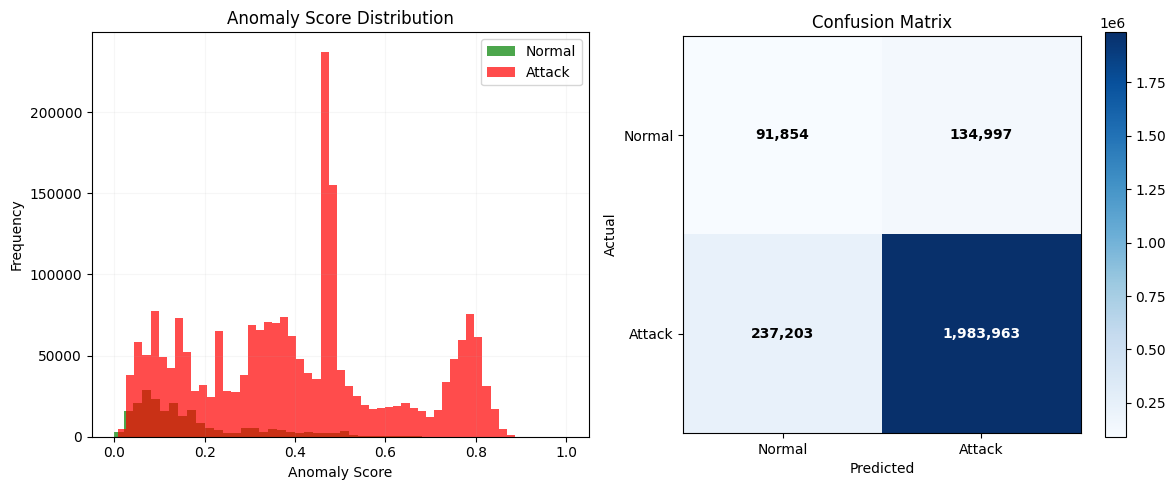

In [13]:
# ============================================================================
# OPTIONAL: VISUALIZATIONS
# ============================================================================

import matplotlib.pyplot as plt

# Plot 1: Anomaly Score Distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_df[test_df['label']==0]['iso_score'], bins=50, alpha=0.7, label='Normal', color='green')
plt.hist(test_df[test_df['label']==1]['iso_score'], bins=50, alpha=0.7, label='Attack', color='red')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Anomaly Score Distribution')
plt.legend()
plt.grid(True, alpha=0.1)

# Plot 2: Confusion Matrix Visualization
plt.subplot(1, 2, 2)
cm_display = np.array([[tn, fp], [fn, tp]])
plt.imshow(cm_display, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks([0, 1], ['Normal', 'Attack'])
plt.yticks([0, 1], ['Normal', 'Attack'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{cm_display[i, j]:,}', ha='center', va='center',
                color='white' if cm_display[i, j] > cm_display.max()/2 else 'black', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/results_visualization.png', dpi=150, bbox_inches='tight')
print(f"✓ Visualization saved to: {OUTPUT_DIR}/results_visualization.png")
plt.show()

✓ Comprehensive visualization saved to: /content/drive/MyDrive/Colab Notebooks/CAN_IDS_Project/Output/comprehensive_results.png


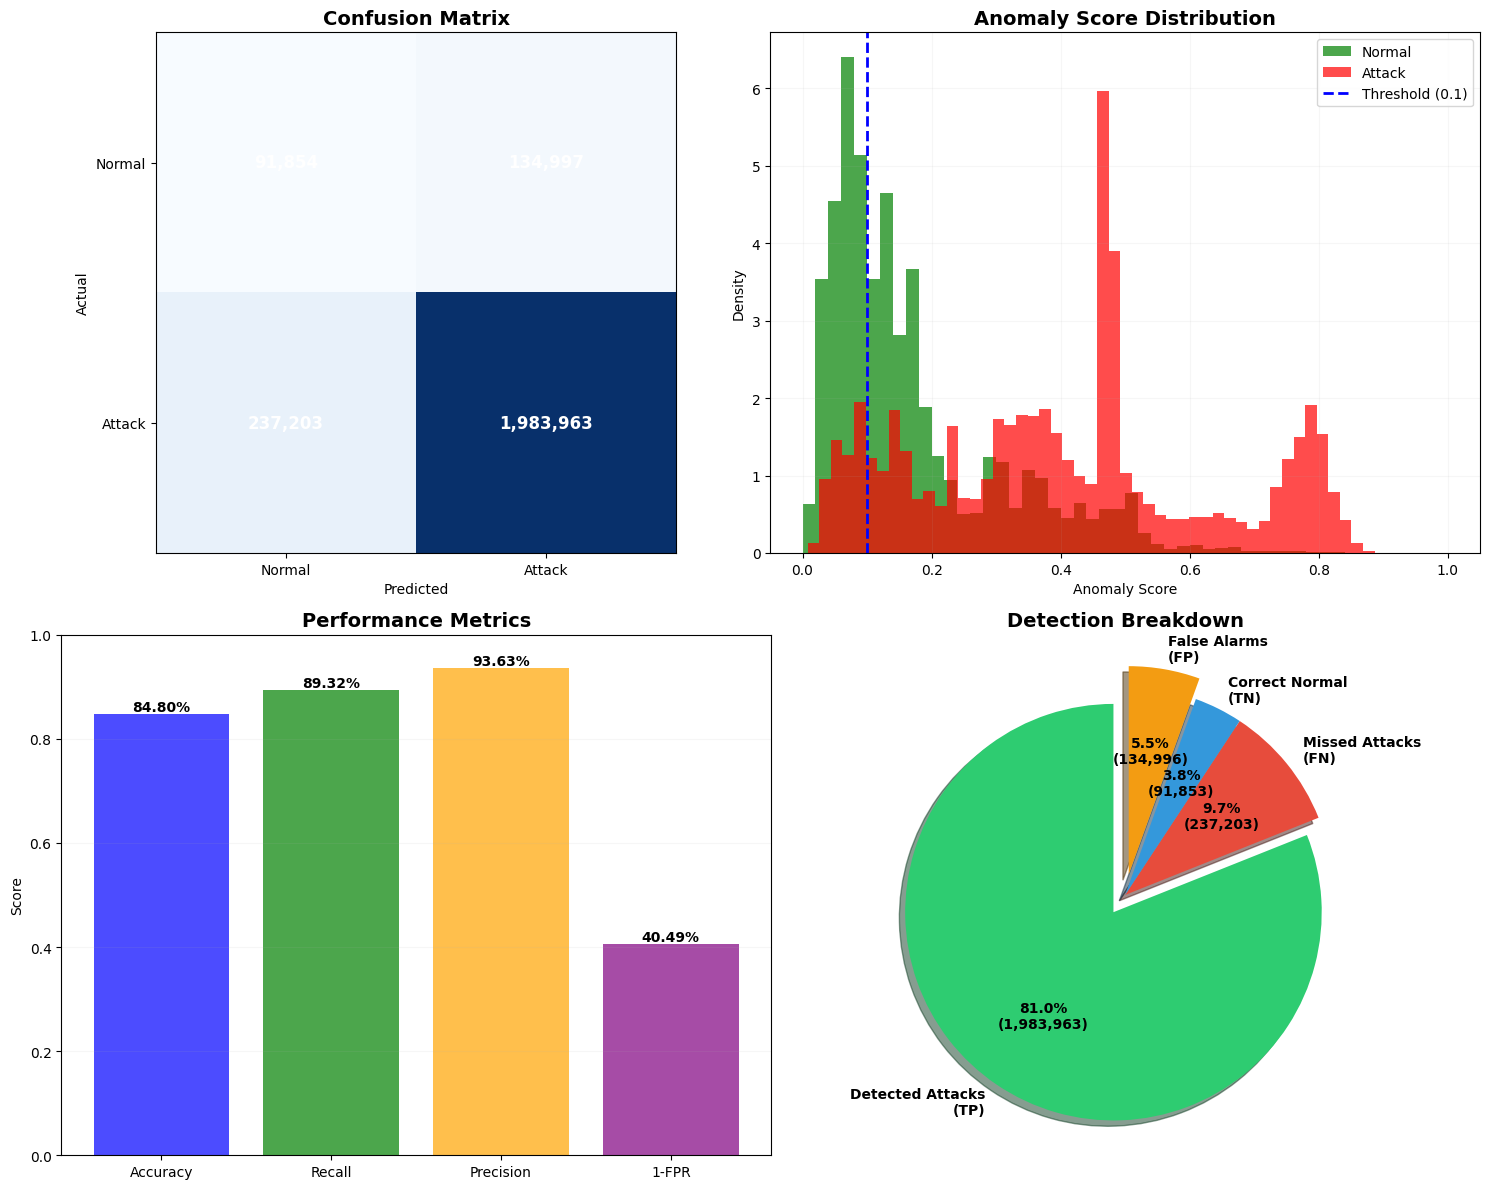

In [14]:
# Enhanced visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Confusion Matrix Heatmap
axes[0, 0].imshow([[tn, fp], [fn, tp]], cmap='Blues', interpolation='nearest')
axes[0, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_yticks([0, 1])
axes[0, 0].set_xticklabels(['Normal', 'Attack'])
axes[0, 0].set_yticklabels(['Normal', 'Attack'])
for i in range(2):
    for j in range(2):
        val = [[tn, fp], [fn, tp]][i][j]
        axes[0, 0].text(j, i, f'{val:,}', ha='center', va='center',
                       color='white' if val > [[tn, fp], [fn, tp]][i][j]/2 else 'black',
                       fontweight='bold', fontsize=12)

# 2. Anomaly Score Distribution
normal_scores = test_df[test_df['label']==0]['iso_score'].values
attack_scores = test_df[test_df['label']==1]['iso_score'].values
axes[0, 1].hist(normal_scores, bins=50, alpha=0.7, label='Normal', color='green', density=True)
axes[0, 1].hist(attack_scores, bins=50, alpha=0.7, label='Attack', color='red', density=True)
axes[0, 1].axvline(x=0.1, color='blue', linestyle='--', linewidth=2, label='Threshold (0.1)')
axes[0, 1].set_xlabel('Anomaly Score')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.1)

# 3. Performance Metrics Bar Chart
metrics = ['Accuracy', 'Recall', 'Precision', '1-FPR']
values = [accuracy, recall, precision, 1-fpr]
colors = ['blue', 'green', 'orange', 'purple']
bars = axes[1, 0].bar(metrics, values, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Performance Metrics', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.1, axis='y')
for bar, val in zip(bars, values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.2%}', ha='center', va='bottom', fontweight='bold')

# 4. Detection Breakdown Pie Chart
labels = ['Detected Attacks\n(TP)', 'Missed Attacks\n(FN)', 'Correct Normal\n(TN)', 'False Alarms\n(FP)']
sizes = [tp, fn, tn, fp]
colors_pie = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
explode = (0.1, 0, 0, 0.1)  # Emphasize TP and FP
axes[1, 1].pie(sizes, explode=explode, labels=labels, colors=colors_pie,
              autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(sizes)):,})',
              shadow=True, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
axes[1, 1].set_title('Detection Breakdown', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/comprehensive_results.png', dpi=200, bbox_inches='tight')
print(f"✓ Comprehensive visualization saved to: {OUTPUT_DIR}/comprehensive_results.png")
plt.show()